In [1]:
#read datafolder from Google Drive
from google.colab import drive
drive.mount('/content/drive')
data_folder = '/content/drive/My Drive/pg2k18/sem2/smai/smai_proj/reuters21578/'

sgml_number_of_files = 21
sgml_file_name_template = 'reut2-NNN.sgm'

# dictionary of category and file name
category_files = {
    'to_': ('Topics', 'all-topics-strings.lc.txt'),
    'pl_': ('Places', 'all-places-strings.lc.txt'),
    'pe_': ('People', 'all-people-strings.lc.txt'),
    'or_': ('Organizations', 'all-orgs-strings.lc.txt'),
    'ex_': ('Exchanges', 'all-exchanges-strings.lc.txt')
  }

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [0]:
# read all category files (total 5) and store the entry in file corresponding to its category
# eg file: 'all-places-strings.lc.txt', entry: 'afghanistan' => category_data = [ [pl_afghanistan, Places], ... ] 

category_data = []

for category_prefix in category_files.keys():
    with open(data_folder + category_files[category_prefix][1], 'r') as file:
        for category in file.readlines():
            category_data.append([category_prefix + category.strip().lower(), 
                                  category_files[category_prefix][0]])

In [4]:
import re
import xml.sax.saxutils as saxutils
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('stopwords')

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
def to_category_vector(categories):
    vector = zeros(len(categories)).astype(float32)
    
    for i in range(len(categories)):
        if target_categories[i] in categories:
            vector[i] = 1.0
    
    return vector

In [0]:
lemmatizer = WordNetLemmatizer()

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;\\n]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def cleanUpSentence(r):#, stop_words = None#
    r = r.lower().replace("<br />", " ")
    r = REPLACE_BY_SPACE_RE.sub(' ', r)
    r = BAD_SYMBOLS_RE.sub('', r)

    r = ' '.join(word for word in r.split() if word not in STOPWORDS)

    words = word_tokenize(r)

    for w in words:
        w = lemmatizer.lemmatize(w)

    return w

In [0]:
# Parse SGML files
def strip_tags(text):
    return re.sub('<[^<]+?>', '', text).strip()

def unescape(text):
    return saxutils.unescape(text)
  
def makeDict(filename, document_X, document_Y):
  with open(filename, 'rb') as file:

    content = BeautifulSoup(file.read().lower(),'html.parser')

    for newsline in content('reuters'):
      document_categories = []

      document_id = newsline['newid']



      document_body = strip_tags(str(newsline('text')[0].body)).replace('reuter\n&#3;', '')
      if document_body == 'None':
        continue

      doc_categories = strip_tags(str(newsline('topics')[0].body))
      doc_categories = unescape(doc_categories)

      document_body = unescape(document_body)

      topics = newsline.topics.contents
      places = newsline.places.contents
      people = newsline.people.contents
      orgs = newsline.orgs.contents
      exchanges = newsline.exchanges.contents

      for topic in topics:
          document_categories.append('to_' + strip_tags(str(topic)))

      for place in places:
          document_categories.append('pl_' + strip_tags(str(place)))

      for person in people:
          document_categories.append('pe_' + strip_tags(str(person)))

      for org in orgs:
          document_categories.append('or_' + strip_tags(str(org)))

      for exchange in exchanges:
          document_categories.append('ex_' + strip_tags(str(exchange)))

      document_X[document_id] = document_body
      document_Y[document_id] = document_categories

def readFiles(test_data = False):
  document_X = {}
  document_Y = {}
  if test_data == True:
    file_name = sgml_file_name_template.replace('NNN', '021')
    filename = data_folder + file_name
    makeDict(filename, document_X, document_Y)
  else:
    for i in range(sgml_number_of_files):
      if i < 10:
        seq = '00' + str(i)
      else:
        seq = '0' + str(i)

      file_name = sgml_file_name_template.replace('NNN', seq)
      print('Reading file: %s' % file_name)
      filename = data_folder + file_name
      makeDict(filename, document_X, document_Y)
  return document_X, document_Y



In [8]:
document_X, document_Y = readFiles()

Reading file: reut2-000.sgm
Reading file: reut2-001.sgm
Reading file: reut2-002.sgm
Reading file: reut2-003.sgm
Reading file: reut2-004.sgm
Reading file: reut2-005.sgm
Reading file: reut2-006.sgm
Reading file: reut2-007.sgm
Reading file: reut2-008.sgm
Reading file: reut2-009.sgm
Reading file: reut2-010.sgm
Reading file: reut2-011.sgm
Reading file: reut2-012.sgm
Reading file: reut2-013.sgm
Reading file: reut2-014.sgm
Reading file: reut2-015.sgm
Reading file: reut2-016.sgm
Reading file: reut2-017.sgm
Reading file: reut2-018.sgm
Reading file: reut2-019.sgm
Reading file: reut2-020.sgm


In [9]:
one_hot_label=[]
for key,v in document_Y.items():
    dict_temp={'Topics':0,'Places':0,'Peoples':0,'Exchanges':0,'Organizations':0}
#     dict_temp = [0,0,0,0,0] #[to, pl, pe, ex, or]
    for i in v:
        string=i.split('_')
        category=string[0]
        if category=='to':
            dict_temp['Topics']+=1
#               dict_temp[0]+=1
        if category=='pl':
            dict_temp['Places']+=1
#               dict_temp[1]+=1
        if category=='ex':
            dict_temp['Exchanges']+=1
#               dict_temp[3]+=1
        if category=='or':
            dict_temp['Organizations']+=1
#               dict_temp[4]+=1
        if category=='pe':
            dict_temp['Peoples']+=1
#               dict_temp[2]+=1
    one_hot_label.append(dict_temp)
print (len(one_hot_label))
ranking=[]
one_hot_label_list = []
for i in one_hot_label:
    sorted_x = sorted(i.items(), key=lambda kv: kv[1], reverse=True) 
    ranking.append(sorted_x)
    one_hot_label_list.append(list(i.values()))
print ("ranking",ranking[0])

print ("one_hot_label_list: ",one_hot_label_list[0])
# all_sorted_x.append(sorted_x)

18583
('ranking', [('Places', 1), ('Organizations', 0), ('Topics', 0), ('Exchanges', 0), ('Peoples', 0)])
('one_hot_label_list: ', [0, 0, 0, 1, 0])


In [0]:
col_names = ['id','body', 'categories', 'encoded-docs','word_count']
dataset = pd.DataFrame(columns = col_names)
# print(document_X['20057'])
# print(document_Y['20057'])

In [11]:
# data preprocessing
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
max_vocab_size = 200
def create_x_matrix(document_X):
    totalX = []
    totalid = []
    for i, doc in document_X.items():
        totalid.append(i)
        totalX.append(cleanUpSentence(doc))
    
    input_tokenizer = Tokenizer(max_vocab_size)
    input_tokenizer.fit_on_texts(totalX)
    encoded_docs = input_tokenizer.texts_to_matrix(totalX, mode='count')
    return totalX,encoded_docs,totalid

totalX,encoded_docs,totalid = create_x_matrix(document_X)

In [13]:
print("len ",len(totalX))
print("type",type(totalX))
print("encoded docs: ",len(encoded_docs), encoded_docs.shape)
print("encoded docs type: ", type(encoded_docs))
print (set(encoded_docs[0]))

('len ', 18583)
('type', <type 'list'>)
('encoded docs: ', 18583, (18583, 200))
('encoded docs type: ', <type 'numpy.ndarray'>)
set([0.0, 1.0, 2.0, 3.0])


In [12]:
#dataset
dataset['id'] = totalid
dataset['body'] = totalX
dataset['encoded-docs'] = encoded_docs.tolist()
dataset['categories'] = one_hot_label_list
dataset['word_count'] = dataset['body'].apply(lambda x: len(str(x).split(" ")))
train, validate = np.split(dataset, [int(.8*len(dataset))])
print (dataset.head())
print (dataset.word_count.describe())

      id                                               body       categories  \
0  20057  first convertible bond issued south korean fir...  [0, 0, 0, 1, 0]   
1  20835  united artists communications inc united cable...  [0, 1, 0, 1, 0]   
2  19719  unicoa corp said agreed merger whollyowned sub...  [0, 1, 0, 1, 0]   
3  20051  brokerage firm ef hutton group inc efh facing ...  [0, 0, 0, 2, 0]   
4  11542  pennzoil co pzl chairman j hugh liedtke told m...  [0, 0, 0, 1, 0]   

                                        encoded-docs  word_count  
0  [0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...          68  
1  [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...          29  
2  [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...          43  
3  [0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, ...          64  
4  [0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, ...          30  
count    18583.000000
mean        90.847441
std         84.624971
min          1.000000
25%         43.000000
50%    

In [15]:
#Identify common words
freq = pd.Series(' '.join(train['body']).split()).value_counts()[:20]
freq

said       41754
mln        19655
dlrs       16081
reuter     14766
pct        13555
vs         10835
000        10166
billion     8074
year        7967
would       7244
us          6797
cts         6660
company     6421
bank        5372
new         5151
inc         5082
last        4629
1986        4550
net         4533
corp        4368
dtype: int64

In [16]:
#Identify uncommon words
freq1 =  pd.Series(' '.join(train ['body']).split()).value_counts()[-20:]
freq1

gardena              1
produyction          1
nearparity           1
0835                 1
0838                 1
intermediaterange    1
punjab               1
priceperbarrel       1
625700               1
jeanmaxime           1
succumbing           1
rollsroycem          1
exaggerate           1
conjnction           1
cnpcs                1
559member            1
premerger            1
biltmores            1
criteriaincrease     1
fawn                 1
dtype: int64

In [0]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline

first convertible bond issued south korean firm overseas samsung electronics co ltd samsse became eligible conversion demand shares government still bans direct share ownership foreigners samsung official said demand holders lead managers made approach us issue shares official said five pct bond colead managed sg warburg goldman sachs co raised 20 mln dlrs issued 1985 korean convertible bonds issued daewoo heavy industries ltd daewse yukong ltd 1986 reuter


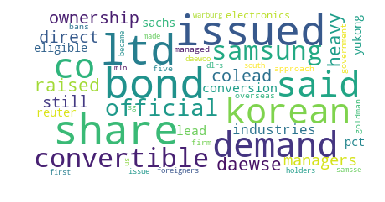

In [18]:
corpus = train.iloc[0]['body']
print (corpus)
stop_words = set(STOPWORDS) 
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

In [0]:
# import math

# def softmax(z):
#     z_exp = [math.exp(i) for i in z]
#     sum_z_exp = sum(z_exp)
#     return [i / sum_z_exp for i in z_exp]

In [13]:
from keras.models import Sequential
from keras.layers import Dense,Flatten, Dropout,Embedding

x = train['encoded-docs']
print ("x[0]:",type(x[0]),len(x[0]))
shape = (1,200)
all_x = []
for i in x:
  data = np.array(i)
  data = data.reshape( shape )
  all_x.append(x)

# x = train['encoded-docs'] #np.array(encoded_docs)

y = np.array(train['categories']) #np.array(one_hot_label_list)
print("all_x: ",type(all_x),len(all_x),)
print("np.array(one_hot_label_list): ",np.array(one_hot_label_list).shape)
print("np.array(encoded_docs): ",np.array(encoded_docs).shape)

('x[0]:', <type 'list'>, 200)
('all_x: ', <type 'list'>, 14866)
('np.array(one_hot_label_list): ', (18583, 5))
('np.array(encoded_docs): ', (18583, 200))


In [0]:
all_x = np.array(all_x)

In [68]:
nn = Sequential()
nn.add(Embedding(1000, 20, input_length=max_vocab_size))
nn.add(Dense(10, activation="relu", input_shape=(max_vocab_size,)))
nn.add(Dropout(0.15))
nn.add(Flatten()) 
nn.add(Dense(5,activation="softmax"))
nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
nn.fit(np.array(encoded_docs), np.array(one_hot_label_list), batch_size=1024, epochs=20, verbose=1, validation_split=0.2)

Train on 14866 samples, validate on 3717 samples
Epoch 1/20
14866/14866 [==============================] - 2s 102us/step - loss: 2.8053 - acc: 0.4430 - val_loss: 2.0801 - val_acc: 0.4533
Epoch 2/20
14866/14866 [==============================] - 1s 89us/step - loss: 1.9410 - acc: 0.4543 - val_loss: 1.8998 - val_acc: 0.4509
Epoch 3/20
14866/14866 [==============================] - 1s 89us/step - loss: 1.8953 - acc: 0.4516 - val_loss: 1.8332 - val_acc: 0.4509
Epoch 4/20
14866/14866 [==============================] - 1s 89us/step - loss: 1.8493 - acc: 0.4516 - val_loss: 1.8110 - val_acc: 0.4506
Epoch 5/20
14866/14866 [==============================] - 1s 90us/step - loss: 1.8140 - acc: 0.4557 - val_loss: 1.7714 - val_acc: 0.4722
Epoch 6/20
14866/14866 [==============================] - 1s 88us/step - loss: 1.7700 - acc: 0.5001 - val_loss: 1.7301 - val_acc: 0.5096
Epoch 7/20
14866/14866 [==============================] - 1s 90us/step - loss: 1.7282 - acc: 0.5398 - val_loss: 1.6963 - val_acc

In [69]:
test_document_X, test_document_Y = readFiles(test_data=True)
print(len(test_document_X))

460


In [70]:
test_total_X,test_encoded_X, _ = create_x_matrix(test_document_X)
y = nn.predict(test_encoded_X)
print (y)

[[3.0421910e-03 3.3290821e-01 7.7986333e-04 6.6221219e-01 1.0576036e-03]
 [5.4045124e-03 1.6019598e-01 2.7509113e-03 8.2461339e-01 7.0352405e-03]
 [6.2759463e-03 2.3559563e-01 1.1720494e-03 7.5485945e-01 2.0969766e-03]
 ...
 [6.3580484e-03 3.5181352e-01 2.5826221e-02 6.0675639e-01 9.2458837e-03]
 [1.2673771e-03 2.6829311e-01 1.1875996e-03 7.2866642e-01 5.8552413e-04]
 [4.4513168e-03 3.2273179e-01 1.7359970e-03 6.6633880e-01 4.7420883e-03]]


In [0]:
def getRankedOutput(predicted_y):
  output=[]
  for i in predicted_y:
      dict_temp={'Topics':i[0],'Places':i[1],'Peoples':i[2],'Exchanges':i[3],'Organizations':i[4]}
      output.append(dict_temp)   
#   print(output)
  ranked_output=[]
  for i in output:
      t={}
      for key, value in sorted(i.items(), key=lambda item: item[1]):
#           print (sorted(i.items(), key=lambda item: item[1]))
          t[key]=value
      rank=0
      for k in t.keys():
          t[k]=rank
          rank+=1
      ranked_output.append(t)


  return ranked_output
# print(y)
# ranked_output = getRankedOutput(y)
# print((ranked_output))


In [71]:
def getRankedOutput2(predicted_y):
  all_sorted_x = []
  for i in predicted_y:
#     print (i)
    dict_temp={'Topics':i[0],'Places':i[1],'Peoples':i[2],'Exchanges':i[3],'Organizations':i[4]}
    sorted_x = sorted(dict_temp.items(), key=lambda kv: kv[1], reverse=True) 
    all_sorted_x.append(sorted_x)
  return all_sorted_x
   
ranked_output = getRankedOutput2(y)
print((ranked_output)) 

[[('Exchanges', 0.6622122), ('Places', 0.3329082), ('Topics', 0.003042191), ('Organizations', 0.0010576036), ('Peoples', 0.00077986333)], [('Exchanges', 0.8246134), ('Places', 0.16019598), ('Organizations', 0.0070352405), ('Topics', 0.0054045124), ('Peoples', 0.0027509113)], [('Exchanges', 0.75485945), ('Places', 0.23559563), ('Topics', 0.0062759463), ('Organizations', 0.0020969766), ('Peoples', 0.0011720494)], [('Exchanges', 0.720499), ('Places', 0.24781899), ('Topics', 0.018537724), ('Peoples', 0.007533544), ('Organizations', 0.005610743)], [('Exchanges', 0.69120914), ('Places', 0.29285148), ('Topics', 0.010730725), ('Organizations', 0.0035684959), ('Peoples', 0.0016401724)], [('Exchanges', 0.54712176), ('Places', 0.4354734), ('Peoples', 0.011636145), ('Topics', 0.0031519816), ('Organizations', 0.0026167054)], [('Exchanges', 0.727675), ('Places', 0.25976014), ('Organizations', 0.005293504), ('Peoples', 0.0049101436), ('Topics', 0.0023612054)], [('Exchanges', 0.6543841), ('Places', 0.

NAIVE BAYES

In [72]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
!pip install scikit-multilearn
from skmultilearn.problem_transform import BinaryRelevance

In [73]:
classifier = BinaryRelevance(MultinomialNB())
classifier.fit(np.array(encoded_docs),np.array(one_hot_label_list))

BinaryRelevance(classifier=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
        require_dense=[True, True])

In [98]:
validate_y = classifier.predict(encoded_docs)
validate_y_array = validate_y.toarray()
print ("validate_y_array",validate_y_array)
validate_ranked_output = getRankedOutput2(validate_y_array)
print(validate_ranked_output)

('validate_y_array', array([[0, 0, 0, 1, 0],
       [0, 0, 0, 2, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0],
       [0, 0, 0, 1, 0]]))
[[('Exchanges', 1), ('Organizations', 0), ('Topics', 0), ('Places', 0), ('Peoples', 0)], [('Exchanges', 2), ('Organizations', 0), ('Topics', 0), ('Places', 0), ('Peoples', 0)], [('Exchanges', 1), ('Organizations', 0), ('Topics', 0), ('Places', 0), ('Peoples', 0)], [('Exchanges', 1), ('Organizations', 0), ('Topics', 0), ('Places', 0), ('Peoples', 0)], [('Exchanges', 1), ('Organizations', 0), ('Topics', 0), ('Places', 0), ('Peoples', 0)], [('Exchanges', 1), ('Places', 1), ('Organizations', 0), ('Topics', 0), ('Peoples', 0)], [('Exchanges', 1), ('Places', 1), ('Organizations', 0), ('Topics', 0), ('Peoples', 0)], [('Organizations', 4), ('Exchanges', 3), ('Places', 3), ('Topics', 1), ('Peoples', 0)], [('Places', 3), ('Organizations', 1), ('Topics', 1), ('Exchanges', 1), ('Peoples', 0)], [('Exchanges', 1), ('Organiz

In [0]:
def permissible(x, y):
  if (abs(x-y)) < 1:
    return True
  else:
    return False

def accuracy(predicted,actual,length):
    tp=0
   
    for one_doc_idx in range(length):
        if permissible(predicted[one_doc_idx][0],actual[one_doc_idx][0]) and permissible(predicted[one_doc_idx][1],actual[one_doc_idx][1])\
          and permissible(predicted[one_doc_idx][2],actual[one_doc_idx][2]) and permissible(predicted[one_doc_idx][3],actual[one_doc_idx][3]):
            tp+=1
    return tp/float(length)

In [33]:
validate_y_list = validate_y_array.tolist()

newv = []
for i in range(len(validate_y_list)):
  validate_y_list_i = list(map(int, validate_y_list[i]))
  newv.append(validate_y_list_i)


# print ("%f"%accuracy(newv, one_hot_label_list, len(newv)))


NameError: ignored

In [84]:
y=classifier.predict(test_encoded_X)
y=y.toarray()
ranked_output = getRankedOutput2(y)
print(ranked_output)

[[('Exchanges', 1), ('Places', 1), ('Organizations', 0), ('Topics', 0), ('Peoples', 0)], [('Exchanges', 2), ('Organizations', 0), ('Topics', 0), ('Places', 0), ('Peoples', 0)], [('Exchanges', 1), ('Places', 1), ('Organizations', 0), ('Topics', 0), ('Peoples', 0)], [('Exchanges', 1), ('Organizations', 0), ('Topics', 0), ('Places', 0), ('Peoples', 0)], [('Exchanges', 2), ('Organizations', 0), ('Topics', 0), ('Places', 0), ('Peoples', 0)], [('Exchanges', 1), ('Organizations', 0), ('Topics', 0), ('Places', 0), ('Peoples', 0)], [('Exchanges', 1), ('Organizations', 0), ('Topics', 0), ('Places', 0), ('Peoples', 0)], [('Exchanges', 9), ('Places', 3), ('Organizations', 1), ('Topics', 1), ('Peoples', 0)], [('Places', 3), ('Exchanges', 2), ('Organizations', 1), ('Topics', 1), ('Peoples', 0)], [('Exchanges', 1), ('Organizations', 0), ('Topics', 0), ('Places', 0), ('Peoples', 0)], [('Exchanges', 1), ('Places', 1), ('Organizations', 0), ('Topics', 0), ('Peoples', 0)], [('Exchanges', 1), ('Places', 1

In [0]:
from sklearn.linear_model import SGDClassifier

In [0]:
classifier = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)

In [102]:
_ = classifier.fit(np.array(encoded_docs),np.array(one_hot_label_list))

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


ValueError: ignored

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [19]:
X = np.array(encoded_docs)
y = np.array(one_hot_label_list)
print (y)

[[0 0 0 1 0]
 [0 1 0 1 0]
 [0 1 0 1 0]
 ...
 [0 1 0 1 0]
 [0 1 0 1 0]
 [0 1 0 2 0]]


In [0]:
clf = DecisionTreeClassifier(random_state=0).fit(X, y)

In [35]:
preds = clf.predict(X)
# print (preds.tolist())

print ("%f"%accuracy(preds.tolist(), one_hot_label_list, len(one_hot_label_list)))

0.993865
